In [1]:
# 繪製各種角度的績效圖

In [2]:
from utils import *

import datetime
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import re
import scikitplot as skplt
import seaborn as sns
import shutil
import sys    
import time


In [3]:
# 初始化繪布
set_default_figure()


In [4]:
# 取得今日日期
today = datetime.date.today().strftime('%Y%m%d')

# 設定目錄名稱 - 不同 test_size 差別
plot_type_name = 'evaluate'


In [5]:
# 工作區
workspace = os.path.join("./plot", today, plot_type_name)

try:
    shutil.rmtree(workspace)
except:
    pass

os.makedirs(workspace)

def getImageName(filename: str):
    """
    取得圖片檔保存路徑
    """
    return os.path.join( workspace, filename )
    

In [6]:
# 載入實驗結果
experiments = load_pickles('exp-')

Loading pickle: ./pickle/exp-LGBMClassifier-20200123.pickle
Loading pickle: ./pickle/exp-KNeighborsClassifier-20200123.pickle
Loading pickle: ./pickle/exp-DecisionTreeClassifier-20200122.pickle
Loading pickle: ./pickle/exp-CatBoostClassifier-20200122.pickle
Loading pickle: ./pickle/exp-RandomForestClassifier-20200124.pickle
Loading pickle: ./pickle/exp-MLPClassifier-20200126.pickle
Loading pickle: ./pickle/exp-ExtraTreesClassifier-20200122.pickle


In [7]:
exp_df = pd.DataFrame()
for key in experiments.keys():
    for exp in experiments[key]:        
#         del exp['train_report']
#         del exp['test_report']
        exp['train_size'] = round((1 - exp['test_size']), 2)
        exp_df = exp_df.append(exp, ignore_index=True)
        
exp_df['random_seed'] = exp_df['random_seed'].astype(int)
exp_df['test_count'] = exp_df['test_count'].astype(int)
exp_df['train_count'] = exp_df['train_count'].astype(int)

In [8]:
# 產生一個成績子集合
scores_df = exp_df[['coordinate', 'random_seed', 'model_name', 'scenario', 'test_cm', 'test_count', 'test_kappa', 'test_report', 'test_size', 'train_size', 'train_count']]


In [9]:
# 整理實驗參數

# 特徵集
coordinate_list = list(scores_df['coordinate'].unique())

# 模型清單
model_list = list(scores_df['model_name'].unique())
model_list.sort()

# 抽樣種子清單
random_seed_list = list(scores_df['random_seed'].unique())
random_seed_list.sort()

# 場景清單
scenario_list = list(scores_df['scenario'].unique())
scenario_list.sort()

# 場景對照表
scenario_dict = {'A': '辦公室', 
                 'B': '實驗室', 
                 'C': '走廊', 
                 'D': '大廳及樓梯口', 
                 'E': '走廊', 
                 'F': '走廊'}

# 訓練資料比例
train_size_list = list(scores_df['train_size'].unique())
train_size_list.sort()


In [10]:
# 同一模型、同一場景、同一訓練資料量、不同抽樣種子、不同特徵組合的比較
# 決定之後使用的特徵組合

# 工作區
workspace = os.path.join("./plot", today, plot_type_name, 'random_seed')
try:
    shutil.rmtree(workspace)
except:
    pass
os.makedirs(workspace)

In [11]:
# 分組欄位
indexes = scores_df['train_size'].unique()
indexes_labels = [f'{n:.0%}' for n in indexes]


In [12]:
# 計算每一個模型、每一個場景、每一個訓練資料比例、每一種座標特徵下三個抽樣種子學習成效的平均值及標準差
# 從原始資料中降低維度到剩下 模型、場景、訓練資料比例、座標系統、學習平均、學習標準差
kappa_mean_df = pd.DataFrame()
conditions = ['coordinate', 'model_name',  'scenario', 'train_size']
groups = scores_df.groupby(conditions)
for name, group in groups:
    rec = { conditions[0]: name[0], 
            conditions[1]: name[1], 
            conditions[2]: name[2], 
            conditions[3]: name[3],  
            'mean_kappa': group['test_kappa'].mean(), 
            'sd_kappa': group['test_kappa'].std()}
    kappa_mean_df = kappa_mean_df.append(rec, ignore_index=True)
    

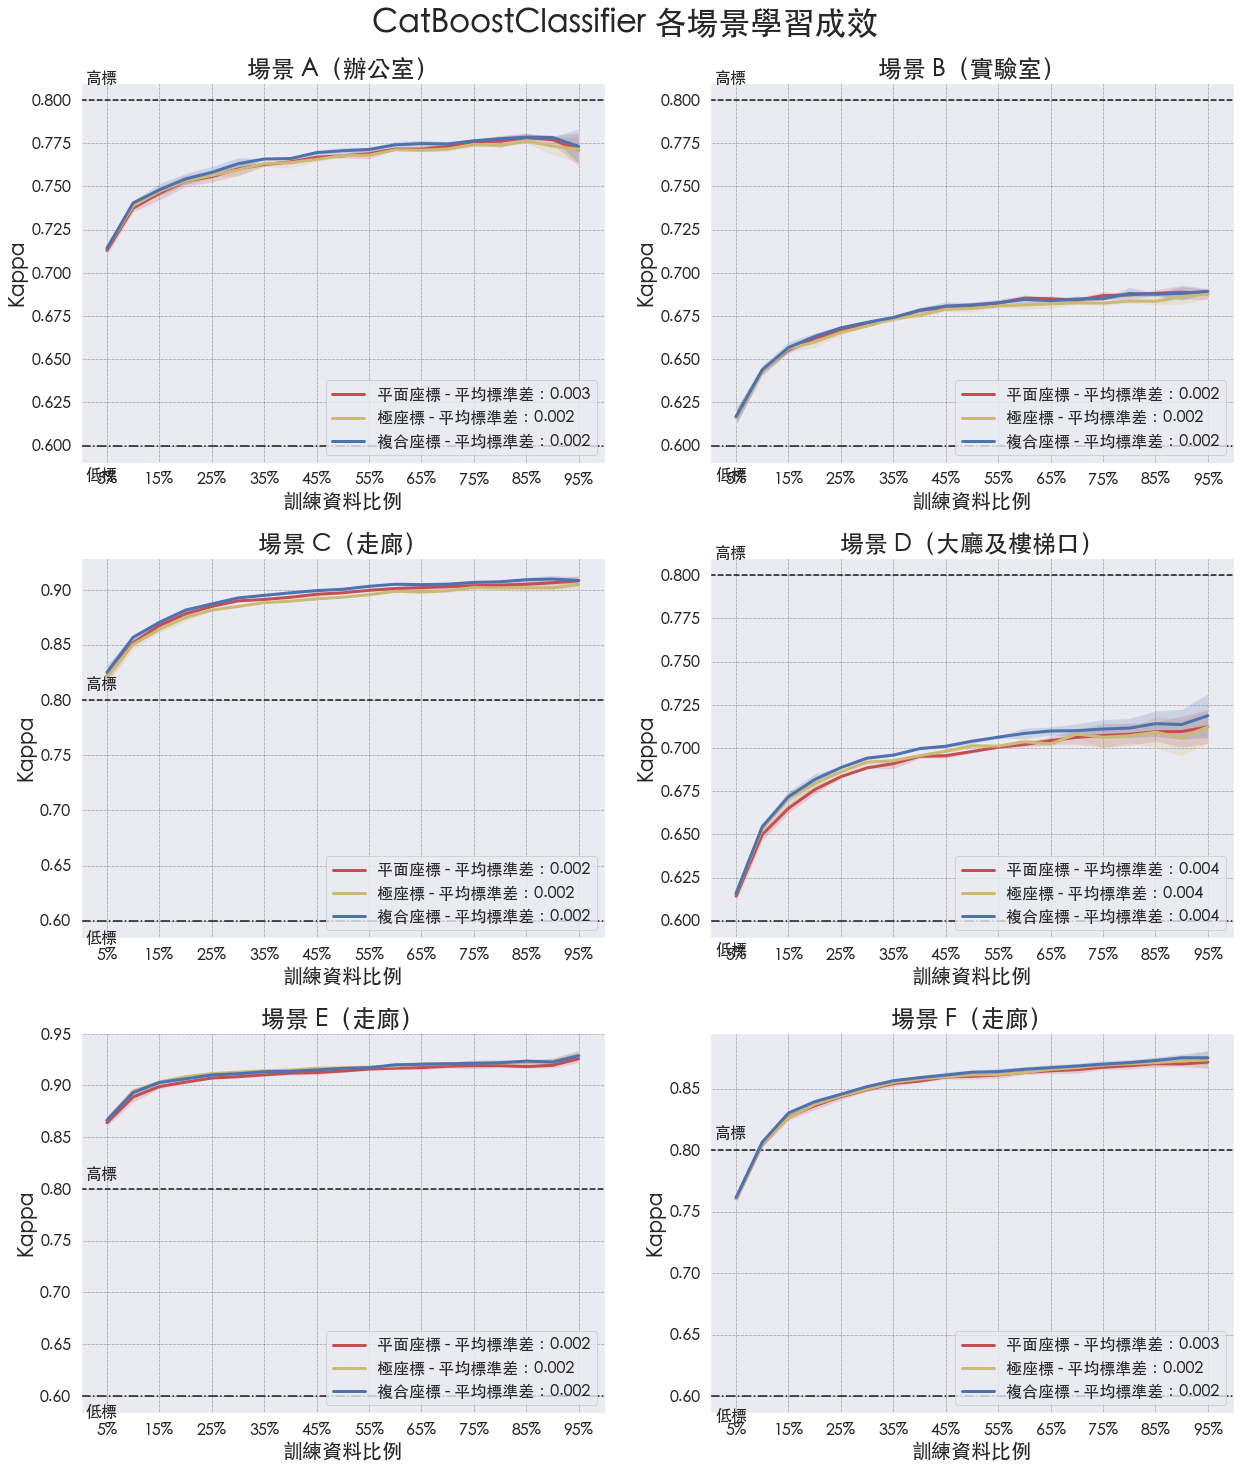

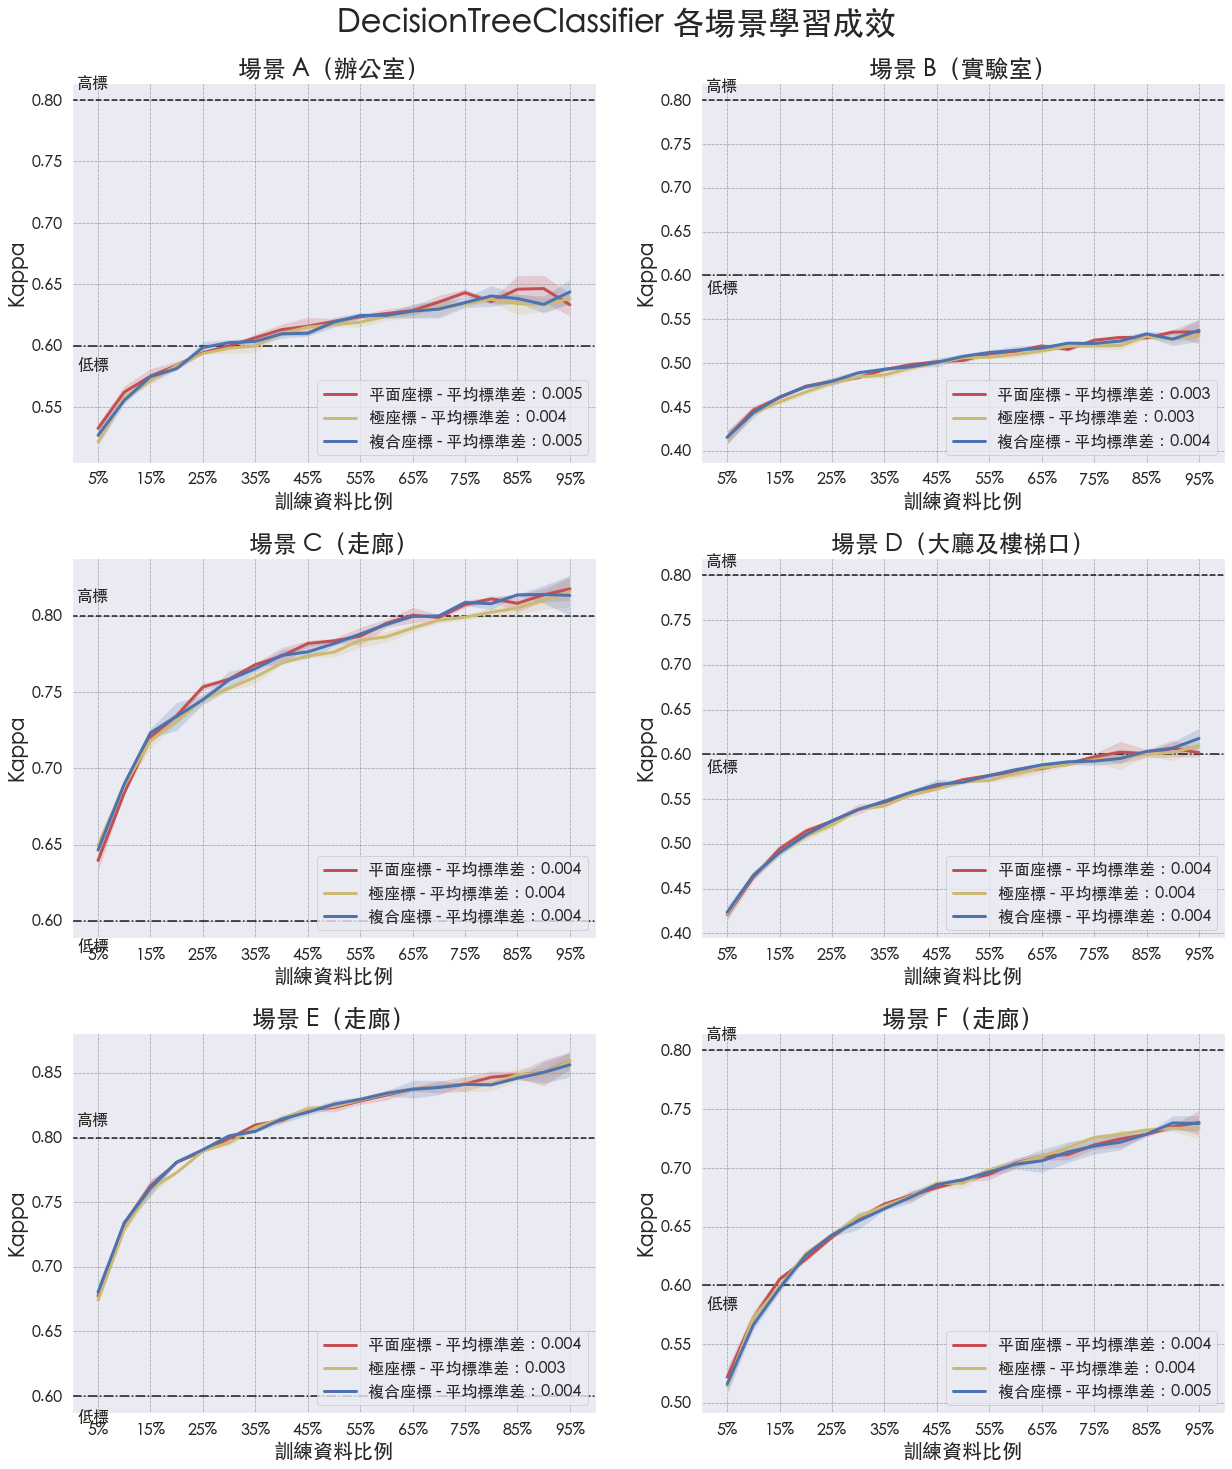

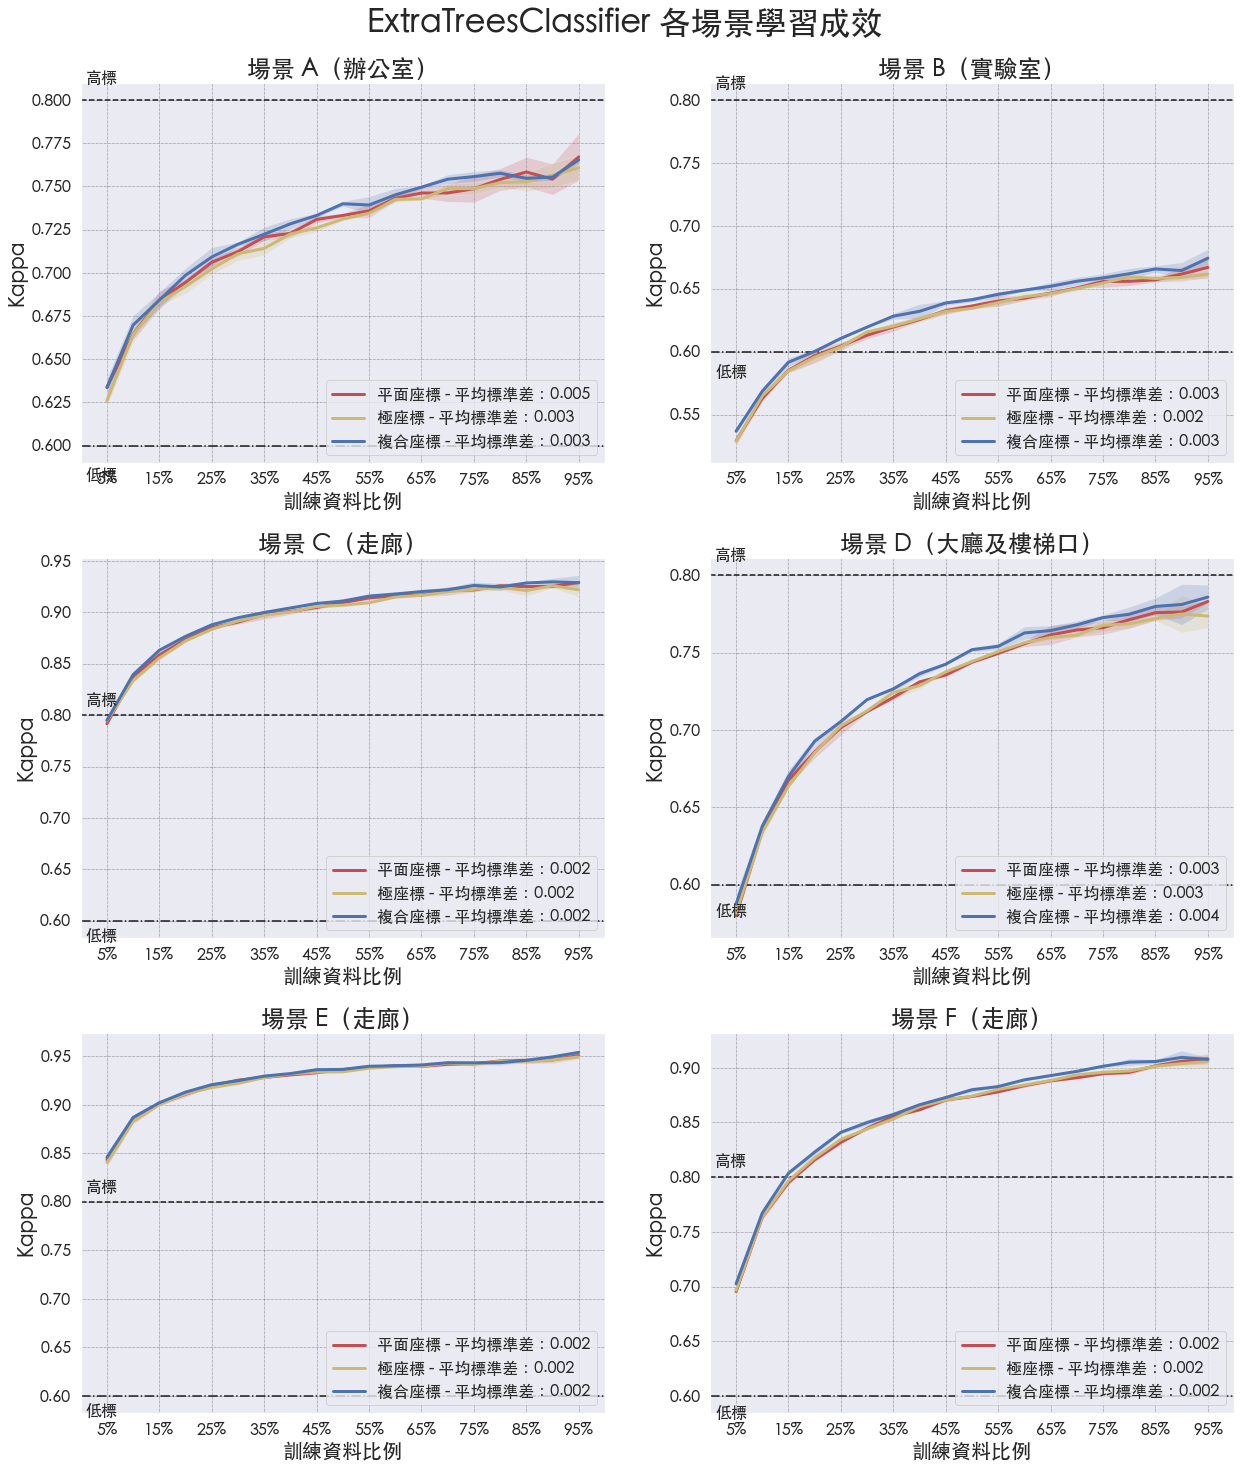

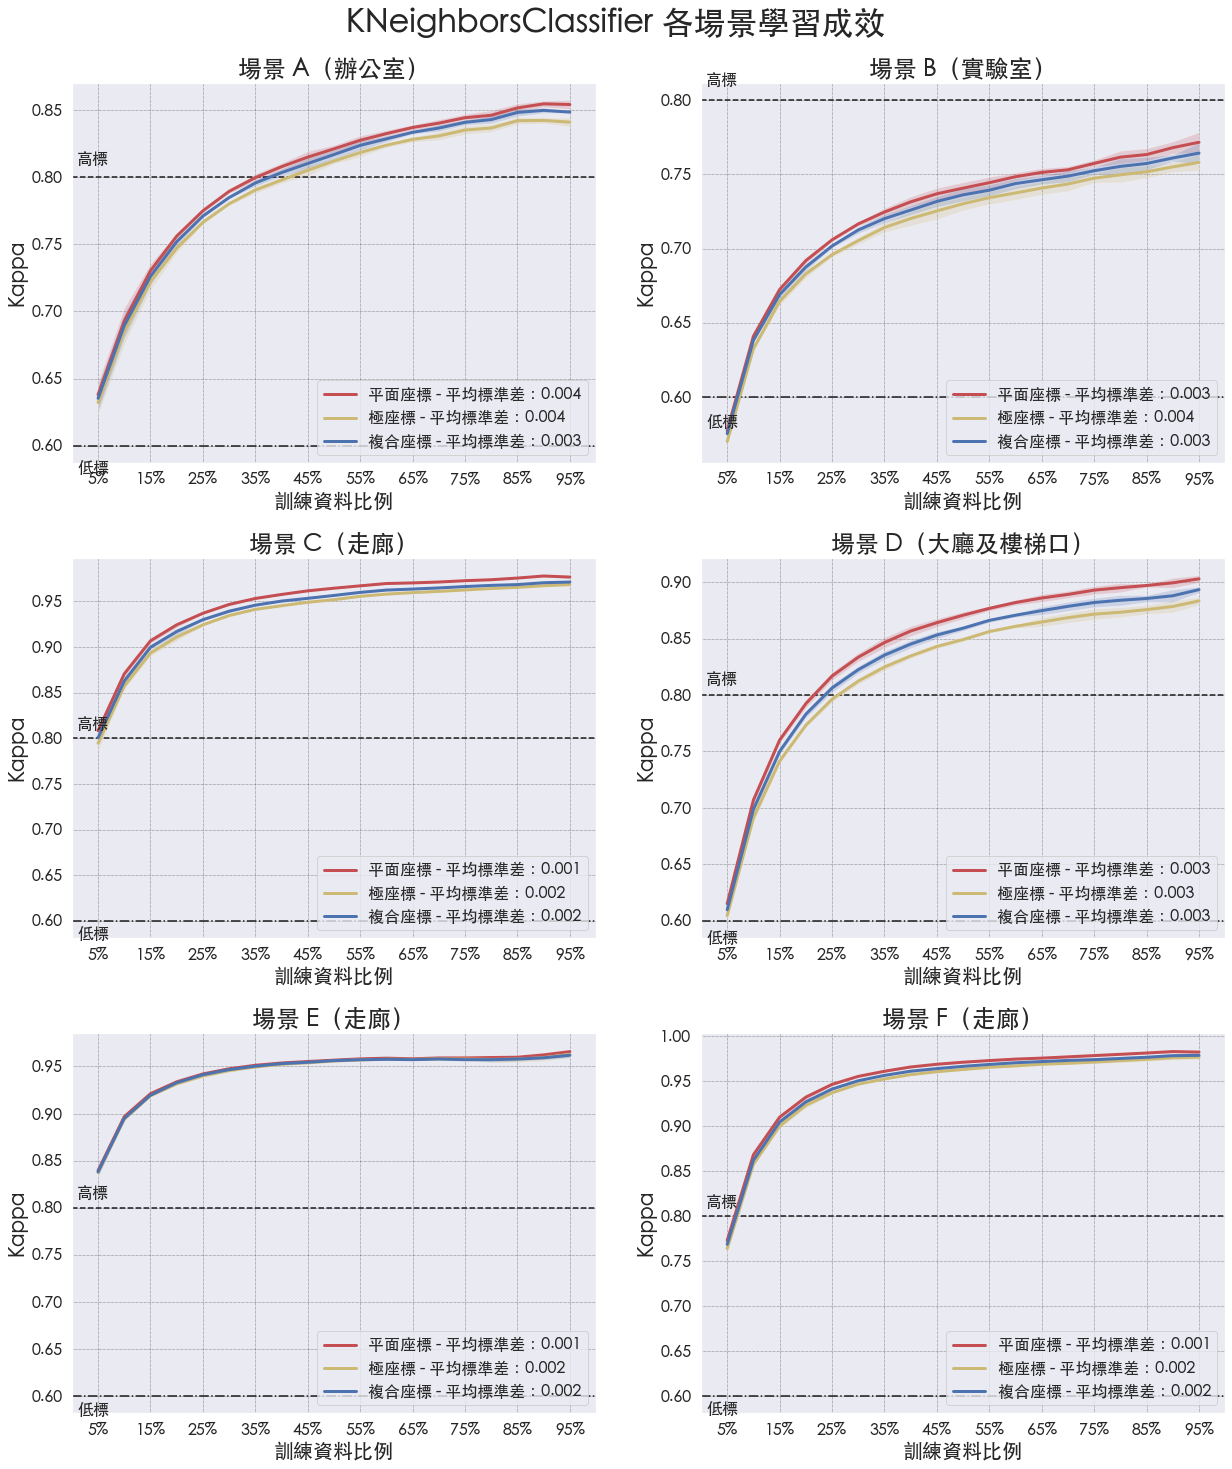

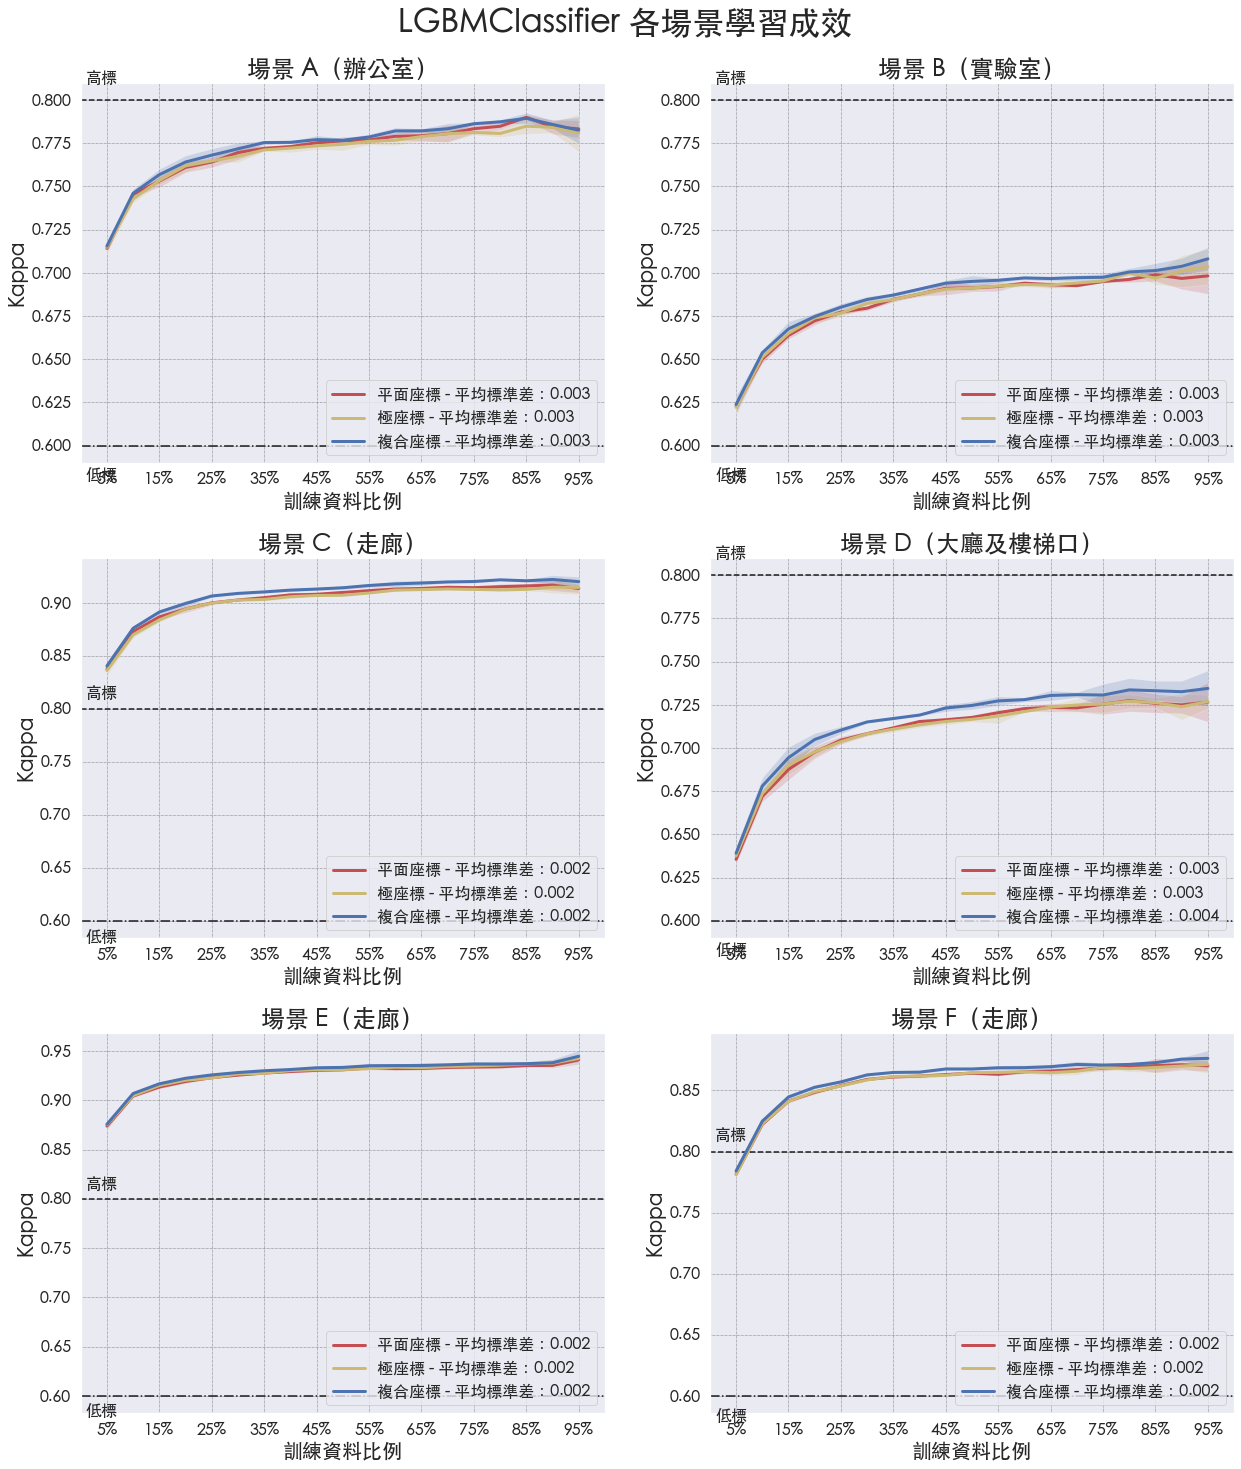

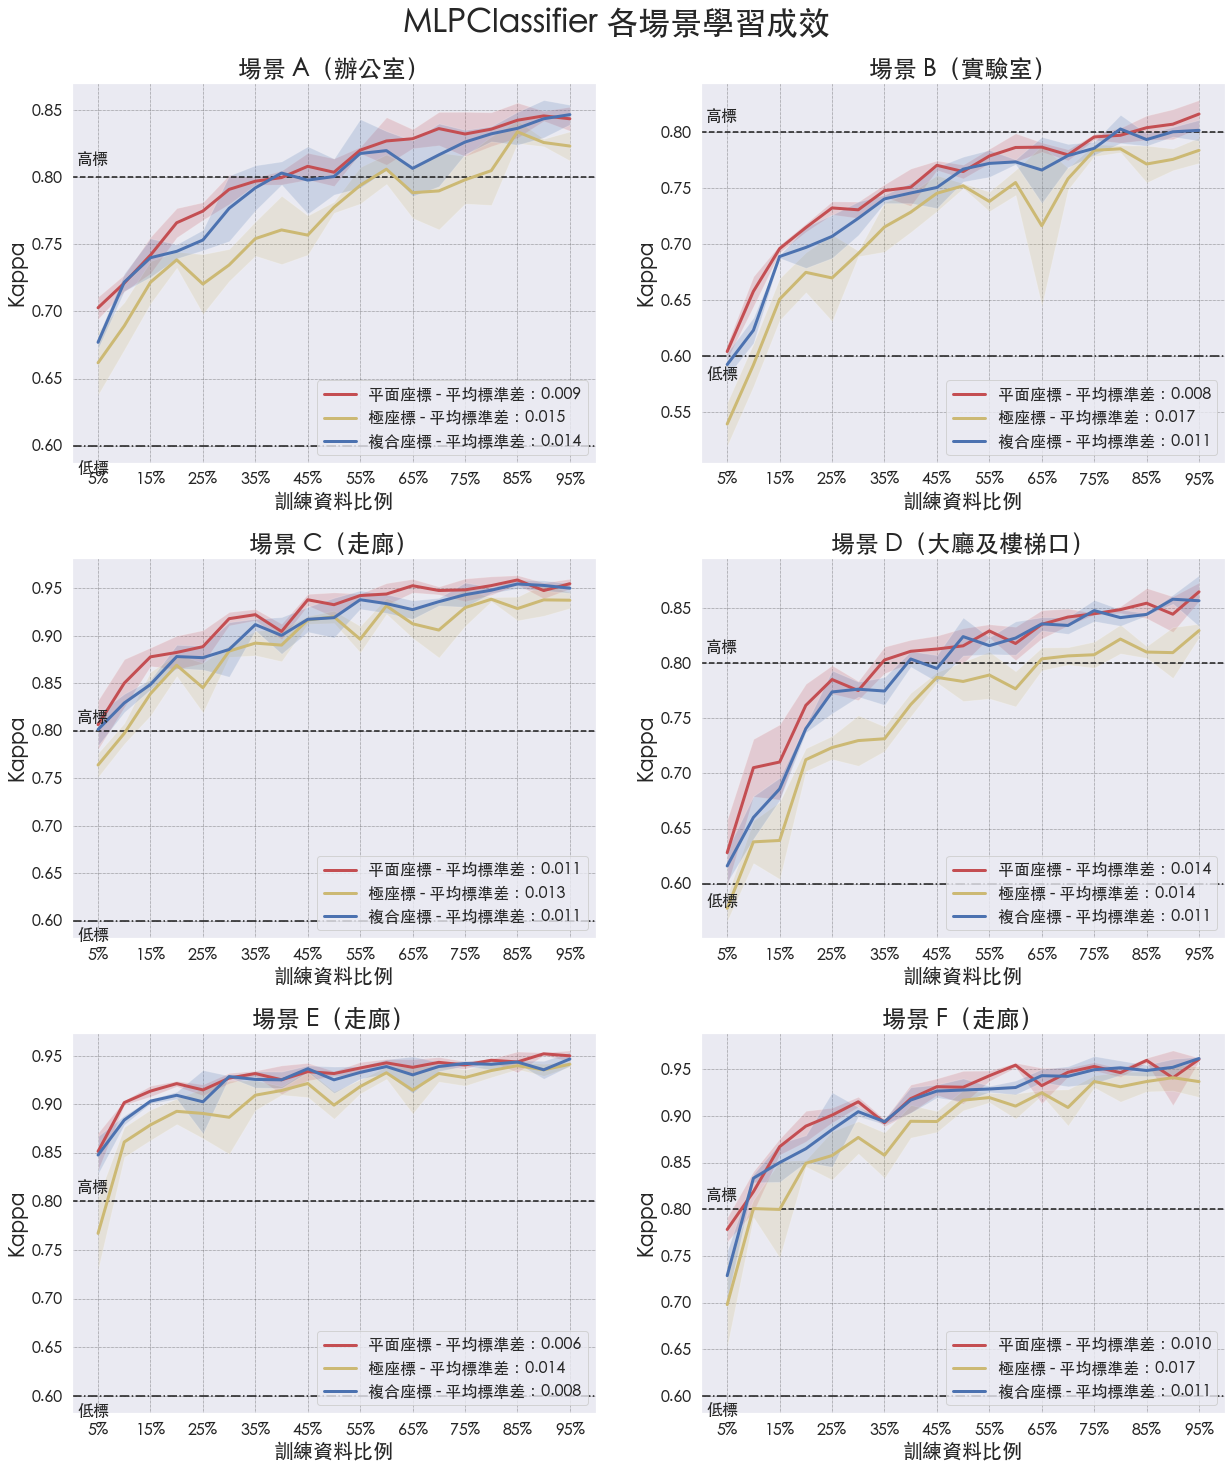

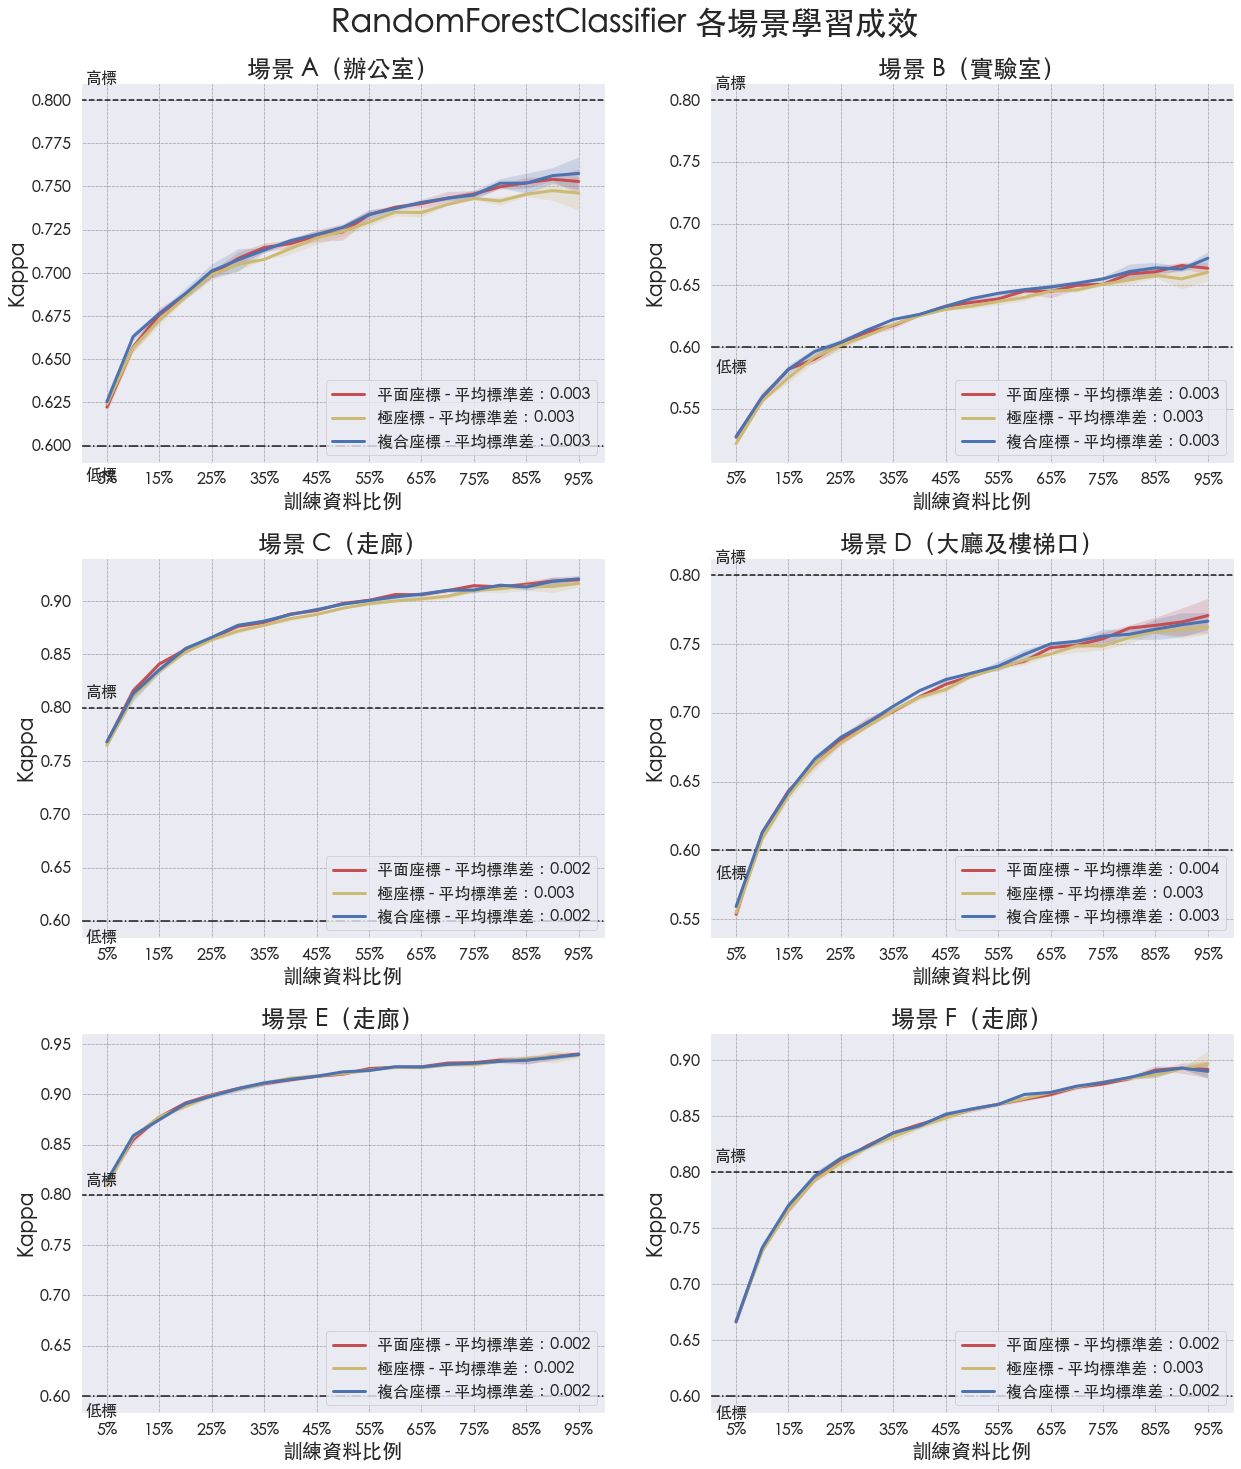

In [13]:

# 圖表佈局方式
column_count = 2
row_count = int(np.ceil(len(scenario_list) / column_count))

# 顏色設定
colors = ['r', 'y', 'b']
# 以模型為分組條件
conditions = ['model_name']
groups = kappa_mean_df.groupby(conditions)

# 記錄各模型、各場景、各座標特徵下所有訓練資料比例的 Kappa 總分及平均值
# 自 kappa_mean_df 的 6 個維度降為 模型、場景、座標系、訓練資料比例 Kappa 的平均與總合
kappa_summary_df = pd.DataFrame()

# 以模型分組
for name, group in groups:
    # 設定繪圖布格局
    plt.subplots(row_count, column_count)
    
    # 依次繪製場景記錄
    for scenario in scenario_list:
        # 撈出指定場景的記錄
        scenario_df = group[group.scenario == scenario]

        # 準備 Legend 標籤
        coordinate_labels = []

        # 整理本次繪製的資料
        seed_df = scenario_df.loc[:, ['coordinate', 'mean_kappa', 'sd_kappa', 'train_size']].copy()

        ax_idx = scenario_list.index(scenario) + 1
        ax = plt.subplot(row_count, column_count, ax_idx)
        

        # 分別繪製三種特徵組合的學習績效曲線
        for coordinate in coordinate_list:
            plot_df = seed_df[seed_df.coordinate == coordinate].copy()
            plot_df = plot_df.loc[:, ['train_size', 'mean_kappa', 'sd_kappa']]
            
            coordinate_cname = coordinate.replace( 'cartesian', '平面座標' ).replace('polar','極座標').replace('full', '複合座標')
            coordinate_labels.append( f"{coordinate_cname} - 平均標準差：{plot_df['sd_kappa'].mean():.03f}" )
            
            # 計算成績
            kappa_sum = {'model_name': name, 'scenario': scenario}
            kappa_sum['coordinate'] = coordinate
            kappa_sum['kappa_sum'] = plot_df['mean_kappa'].sum()
            kappa_sum['kappa_mean'] = plot_df['mean_kappa'].mean()
            kappa_summary_df = kappa_summary_df.append( kappa_sum, ignore_index = True)

            # 指定索引
            plot_df.set_index('train_size', inplace=True)
            color_idx = coordinate_list.index(coordinate)
            plot_df.loc[:,['mean_kappa']].plot(ax=ax, xlim=(0,1.0), color=colors[color_idx], linewidth=3, legend = False)
            # 繪製 平均值 ± 標準差 區間
            uplimit = plot_df['mean_kappa'] + plot_df['sd_kappa']
            lowlimit = plot_df['mean_kappa'] - plot_df['sd_kappa']
            ax.fill_between(plot_df.index, uplimit, lowlimit, facecolor=colors[color_idx], alpha=0.2)
            
        # x 軸標籤
        ax.set_xticks([indexes[idx] for idx in range(len(indexes)) if idx % 2 == 0])
        ax.set_xticklabels([indexes_labels[idx] for idx in range(len(indexes_labels)) if idx % 2 == 0])
        ax.set_xlabel("訓練資料比例", fontsize=20)
        ax.set_ylabel("Kappa", fontsize=20)
        xlim = ax.get_xlim()
        ax.hlines(0.6, xlim[0], xlim[1], linestyle='dashdot' )
        ax.hlines(0.8, xlim[0], xlim[1], linestyle='dashed'  )        
        ax.text(xlim[0] + 0.01, 0.58, '低標')
        ax.text(xlim[0] + 0.01, 0.81, '高標')
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.legend(coordinate_labels, fontsize=16, loc='lower right')
        ax.set_title(f"場景 {scenario}（{scenario_dict[scenario]}）", fontsize=24)
        
        
    plt.subplots_adjust(bottom=0.05, top=0.93, left=0.08, right=0.97, hspace=0.25, wspace=0.2)
    plt.suptitle(f'{name} 各場景學習成效', fontsize=32)
    imgName = getImageName(f'{name}.png')
    plt.savefig(imgName)
    plt.show()
    plt.close()


In [14]:
# 計算各模型適用之資料特徵

# 記錄 kappa_summary_df 中 模型、場景下那一個座標系的 kappa 平均最高
# 只保留該座標系的記錄
coordinate_scores = pd.DataFrame()

for model_name in model_list:
    for scenario in scenario_list:
        filter = (kappa_summary_df.scenario == scenario) & (kappa_summary_df.model_name == model_name)
        m = kappa_summary_df[filter]['kappa_mean'].idxmax()
        
        data = { 'model_name': model_name, 
                 'scenario': scenario, 
                 'coordinate': kappa_summary_df.loc[m, 'coordinate'],
                 'kappa_sum': kappa_summary_df.loc[m, 'kappa_sum'], 
                 'kappa_mean': kappa_summary_df.loc[m, 'kappa_mean']}
        coordinate_scores = coordinate_scores.append(data, ignore_index = True)

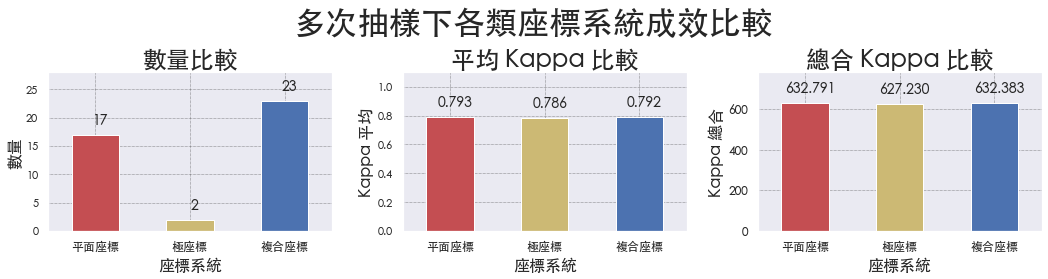

In [15]:
# 存檔目錄
workspace = os.path.join("./plot", today, plot_type_name)

# 座標特徵條件
coordinate_labels = [ s.replace( 'cartesian', '平面座標' ).replace('polar','極座標').replace('full', '複合座標') for s in coordinate_list ]


# 圖表格局
plt.subplots(1, 3, figsize=(15, 4))
# 色彩
# colors = plt.cm.Set2(np.linspace(.1, .9, len(coordinate_list)))
colors = ['ryb']


# 比較個數
plot_df = pd.DataFrame()

# 記錄各座標系統 kappa 的平均值
kappa_mean = {}

# 記錄各座標系統 kappa 的總合
kappa_sum = {}

# 從 coordinate_scores 中找到各自座標系的領先數量
for coordinate in coordinate_list:
    data = { 'coordinate': coordinate, 
             'count': coordinate_scores[coordinate_scores.coordinate == coordinate].shape[0]}
    kappa_mean[coordinate] = kappa_summary_df[kappa_summary_df.coordinate == coordinate]['kappa_mean'].mean()
    kappa_sum[coordinate] = kappa_summary_df[kappa_summary_df.coordinate == coordinate]['kappa_sum'].sum()
    plot_df = plot_df.append( data, ignore_index=True)

plot_df.set_index('coordinate', inplace=True)
plot_df['count'] = plot_df['count'].astype(int)
max_y = plot_df['count'].max() + 5

# 第一張圖
ax = plt.subplot(1,3,1)

plot_df.plot(kind='bar', ax = ax, legend=False, ylim=(0, max_y), color=colors)
ax.set_xticklabels(coordinate_labels,fontsize=12, rotation=0)
ax.set_ylabel('數量', fontsize=16)
ax.set_xlabel('座標系統', fontsize=16)
ax.set_title('數量比較', fontsize=24)
# plt.legend(['優勢數量'], fontsize=16)

# 標示數字
for idx, label in enumerate(list(plot_df.index)): 
    for acc in plot_df.columns:
        value = plot_df.iloc[idx][acc]
        ax.annotate(f'{value}',
                    (idx, value),
                     xytext=(5, 10), 
                     textcoords='offset points',
                    ha='center',
                    fontsize=14
                   )
        
# 比較績效 - 績效平均值
plot_df = pd.DataFrame()
for key in kappa_mean.keys():
    data = { 'coordinate': key, 'kappa_mean': kappa_mean[key]}
    plot_df = plot_df.append(data, ignore_index=True)

plot_df.set_index('coordinate', inplace=True)

# 第二張圖 - 績效平均值
ax = plt.subplot(1,3,2)
plot_df.plot(kind='bar', ax = ax, legend=False, ylim=(0, 1.1), color=colors)
ax.set_xticklabels(coordinate_labels,fontsize=12, rotation=0)
ax.set_ylabel('Kappa 平均', fontsize=16)
ax.set_xlabel('座標系統', fontsize=16)
ax.set_title('平均 Kappa 比較', fontsize=24)

# 標示數字
for idx, label in enumerate(list(plot_df.index)): 
    for acc in plot_df.columns:
        value = plot_df.iloc[idx][acc]
        ax.annotate(f'{value:.03f}',
                    (idx, value),
                     xytext=(5, 10), 
                     textcoords='offset points',
                    ha='center',
                    fontsize=14
                   )
        
plot_df = pd.DataFrame()
for key in kappa_sum.keys():
    data = { 'coordinate': key, 'kappa_sum': kappa_sum[key]}
    plot_df = plot_df.append(data, ignore_index=True)

plot_df.set_index('coordinate', inplace=True)

# 第三張圖 - 績效總合
ax = plt.subplot(1,3,3)
plot_df.plot(kind='bar', ax = ax, legend=False, color=colors, ylim=(0, plot_df['kappa_sum'].max() + 150))
ax.set_xticklabels(coordinate_labels, rotation=0)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel('Kappa 總合', fontsize=16)
ax.set_xlabel('座標系統', fontsize=16)
ax.set_title('總合 Kappa 比較', fontsize=24)

# 標示數字
for idx, label in enumerate(list(plot_df.index)): 
    for acc in plot_df.columns:
        value = plot_df.iloc[idx][acc]
        ax.annotate(f'{value:.03f}',
                    (idx, value),
                     xytext=(5, 10), 
                     textcoords='offset points',
                    ha='center',
                    fontsize=14
                   )

plt.subplots_adjust(bottom=0.2, top=0.75, left=0.05, right=0.97, hspace=0, wspace=0.25)
plt.suptitle(f'多次抽樣下各類座標系統成效比較', fontsize=32)
imgName = getImageName('coordinate.png')
plt.savefig(imgName)
plt.show()
plt.close()

In [16]:
index = train_size_list

markers = ['s', 'o', 'X', 'v', '^', 'H', 'p', 'D', '*']


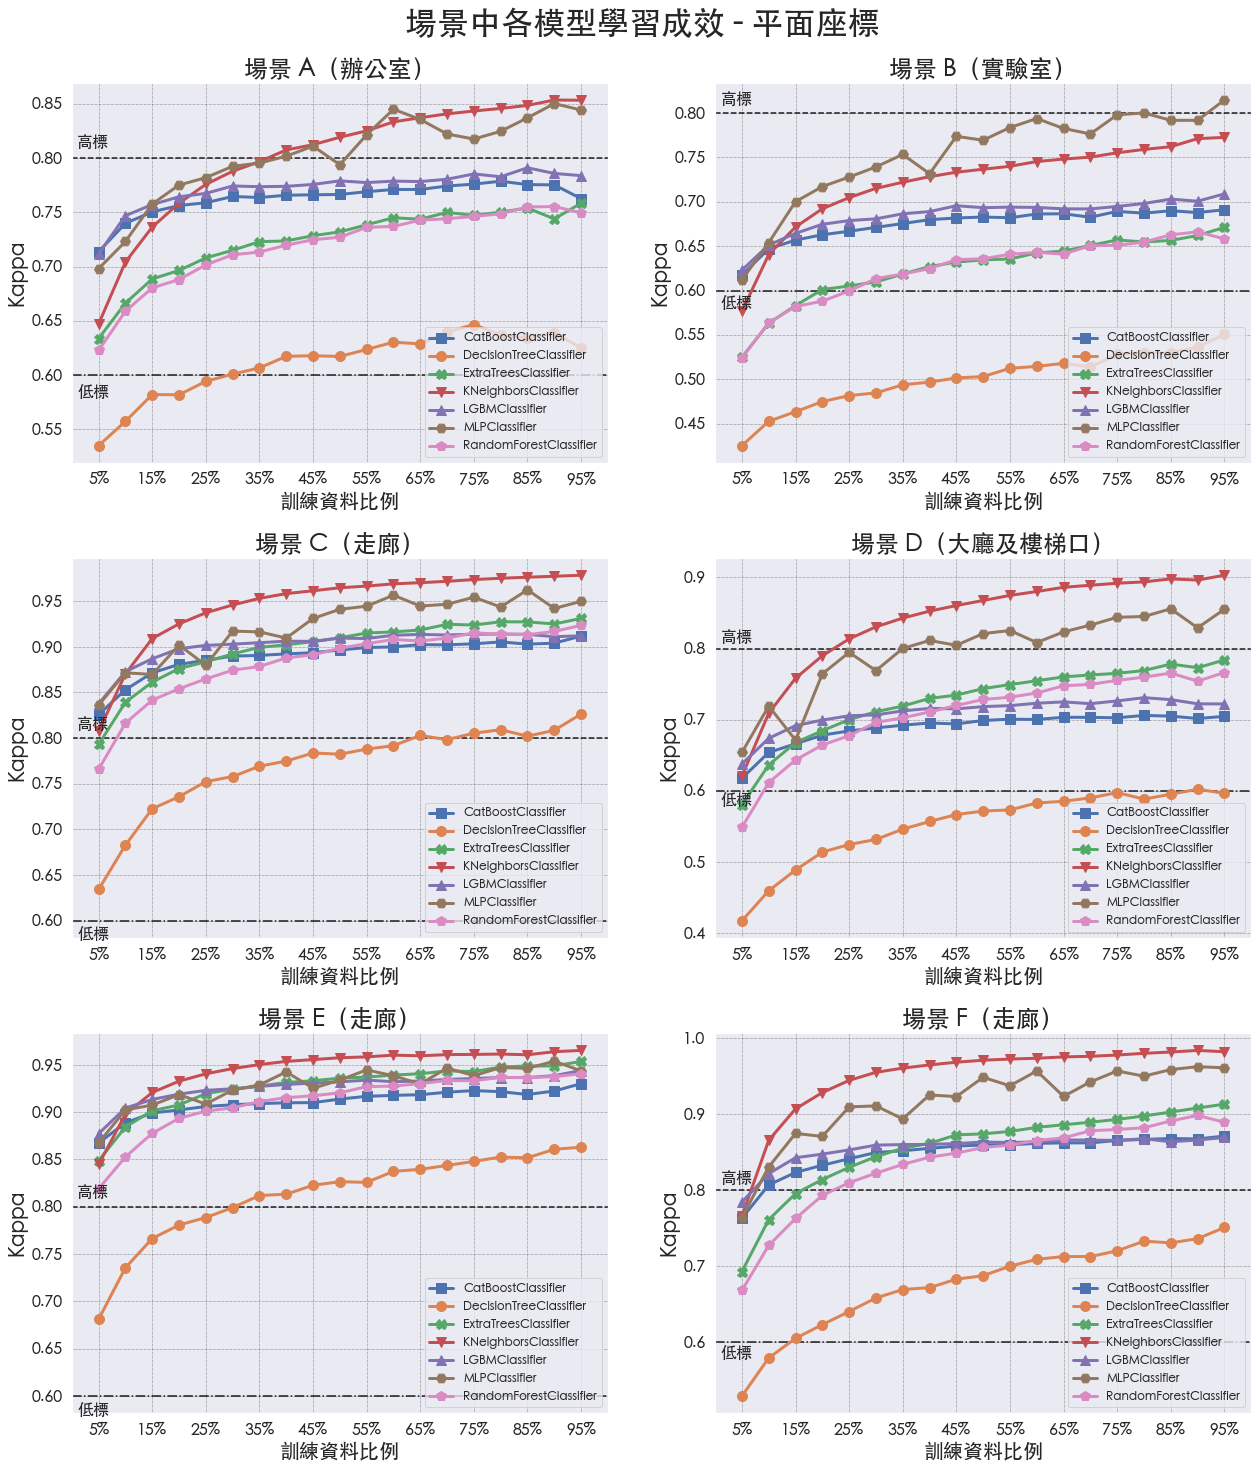

In [17]:
# 使用的座標系統
# coordinate = 'cartesian'

# 使用的隨機種子
random_seed = 3

# 欄位名稱為 模型列表
columns = model_list

# for coordinate in ['cartesian', 'full']:
for coordinate in ['cartesian']:
    
    coordinate_lable = coordinate.replace( 'cartesian', '平面座標' ).replace('polar','極座標').replace('full', '複合座標')
    
    scenario_df = scores_df[(scores_df.coordinate == coordinate) & (scores_df.random_seed == 3)]

    # 每列 2 欄
    column_count = 2
    row_count = int(np.ceil(len(scenario_list) / column_count))

    plt.subplots(row_count, column_count)

    groups = scenario_df.groupby('scenario')
    for name, group in groups:

        plot_df = pd.DataFrame(columns = columns, index = index)
        for idx, row in group.iterrows():
            plot_df.loc[row['train_size'], row['model_name']] = row['test_kappa']


        ax = plt.subplot(row_count, column_count, scenario_list.index(name) + 1)
        plot_df.plot(ax=ax, xlim=(0,1.0), linestyle='-', linewidth=3, markersize=10, style=markers)
        ax.legend(fontsize=12, loc="lower right")
        xlim = plt.gca().get_xlim()
        ax.hlines(0.6, xlim[0], xlim[1], linestyle='dashdot' )
        ax.hlines(0.8, xlim[0], xlim[1], linestyle='dashed'  )
        ax.text(xlim[0] + 0.01, 0.58, '低標')
        ax.text(xlim[0] + 0.01, 0.81, '高標')
        ax.set_title(f'場景 {name}（{scenario_dict[name]}）', fontsize=24)

        ax.set_xticks([indexes[idx] for idx in range(len(indexes)) if idx % 2 == 0])
        ax.set_xticklabels([indexes_labels[idx] for idx in range(len(indexes_labels)) if idx % 2 == 0])
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_xlabel("訓練資料比例", fontsize=20)
        ax.set_ylabel("Kappa", fontsize=20)

    plt.suptitle(f"場景中各模型學習成效 - {coordinate_lable}", fontsize=32)
    plt.subplots_adjust(bottom=0.05, top=0.93, left=0.06, right=0.97, hspace=0.25, wspace=0.2)
    imgName = getImageName(f'scenario-{coordinate}.png')
    plt.savefig(imgName)
    plt.show()
    plt.close()


In [18]:
# 計算抽樣種子 3 的條件下出現 overfitting 的訓練狀況

overfitting_df = exp_df[(exp_df.train_kappa == 1) & (exp_df.coordinate == 'cartesian') & (exp_df.random_seed == 3)][['model_name', 'scenario', 'train_size', 'train_kappa', 'test_kappa']].copy()

# 記錄模型 - 場景組合出現訓練 Kappa 值 == 1 的次數
overfit_count_df = pd.DataFrame(columns = scenario_list, index = model_list)
overfit_count_df.fillna(0, inplace=True)

# 以訓練資料集的 Kappa 值 - 驗證資料集的 Kappa > 0.2 時視為有 overfit 可能
for idx, row in overfitting_df.iterrows():
    if abs(row['train_kappa'] - row['test_kappa']) > 0.2:
        overfit_count_df.loc[row['model_name'], row['scenario']] += 1

print(f"目前每組模型在每個場景的訓練次數為：{len(train_size_list)}")

目前每組模型在每個場景的訓練次數為：19


In [19]:
# 顯示各模型訓練資料集 Kappa 值 - 驗證資料集 Kappa 值 > 0.2 的次數
# 註：每個模型在每個場景共執行 len(train_size_list) 次訓練，目前這個值是 19
overfit_count_df

A   B   C   D  E   F
CatBoostClassifier       0   0   0   0  0   0
DecisionTreeClassifier  19  19  13  19  6  19
ExtraTreesClassifier    19  19   1  19  0   3
KNeighborsClassifier     0   0   0   0  0   0
LGBMClassifier           1   1   0   0  0   1
MLPClassifier            0   0   0   0  0   0
RandomForestClassifier   0   0   0   0  0   0

In [20]:
# 使用的座標系統
# coordinate = 'cartesian'

# 使用的隨機種子
random_seed = 3

# 欄位名稱為 場景列表
columns = scenario_list

# 用於進行比較的訓練資料比例
size_baseline = [0.05, 0.25]


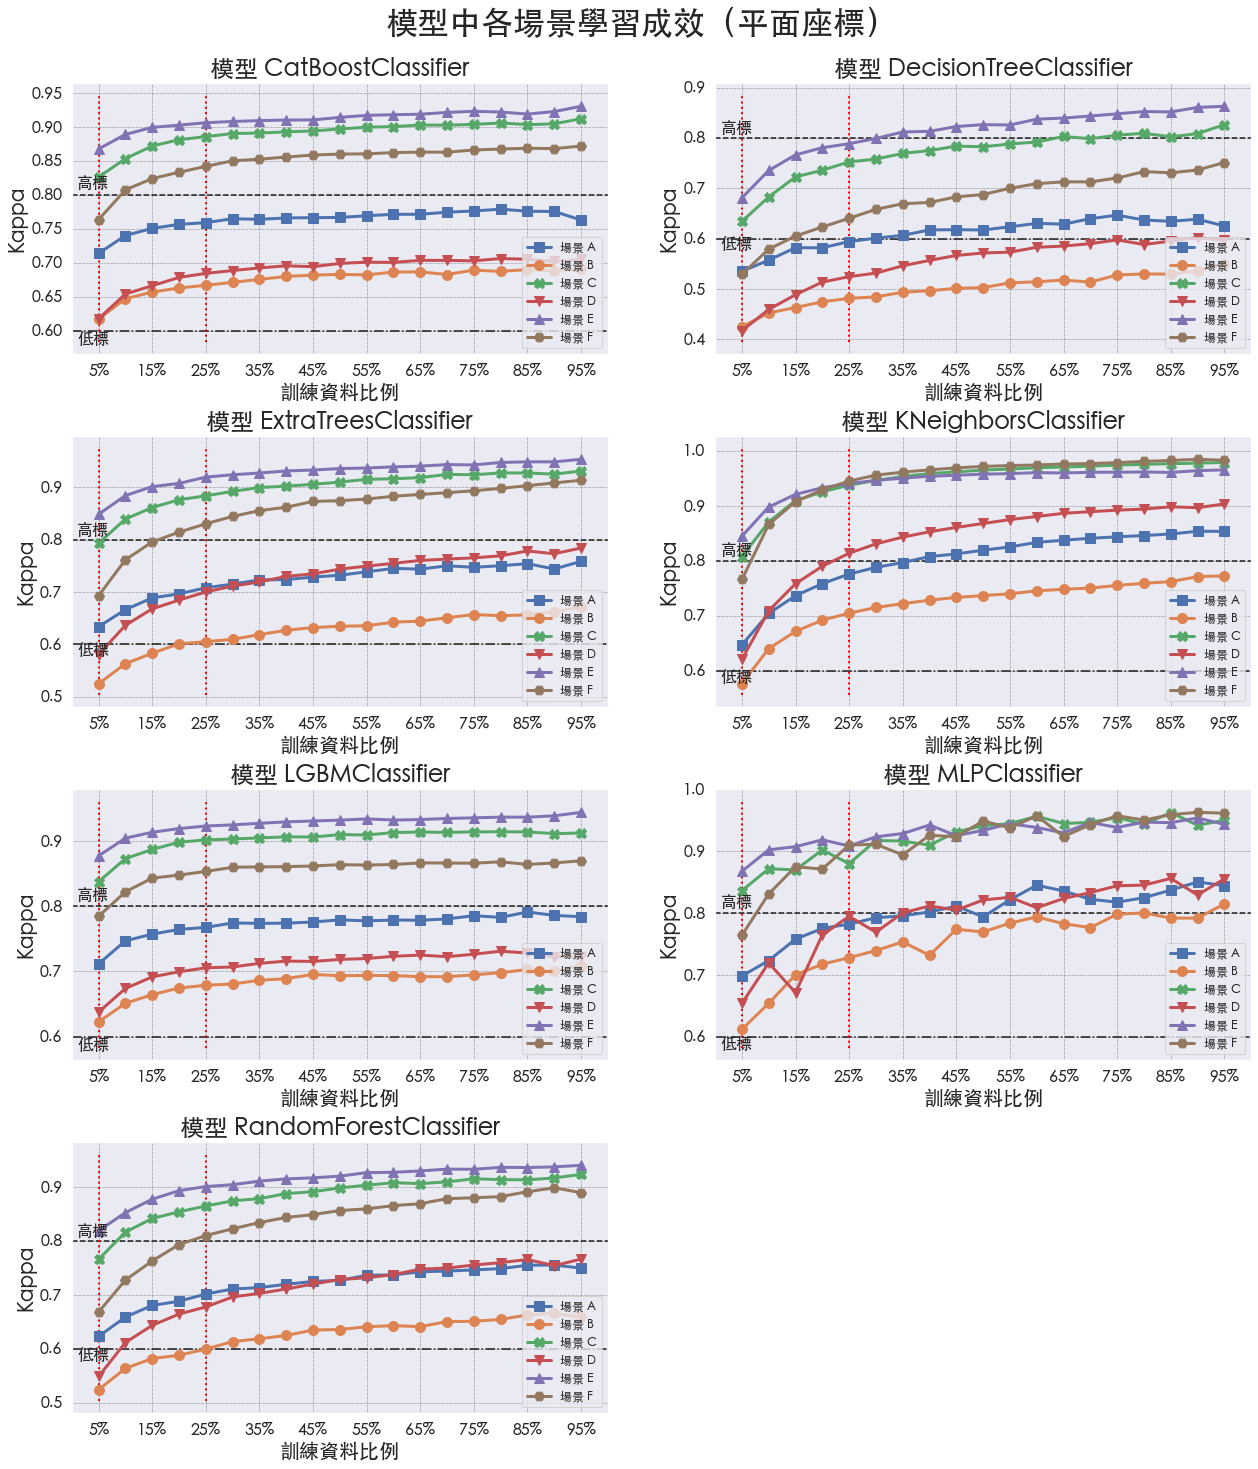

In [21]:


# for coordinate in ['cartesian', 'full']:
for coordinate in ['cartesian']:
    
    coordinate_lable = coordinate.replace( 'cartesian', '平面座標' ).replace('polar','極座標').replace('full', '複合座標')
    
    model_df = scores_df[(scores_df.coordinate == coordinate) & (scores_df.random_seed == 3)]

    # 每列 2 欄
    column_count = 2
    row_count = int(np.ceil(len(model_list) / column_count))

    plt.subplots(row_count, column_count)

    groups = model_df.groupby('model_name')
    for name, group in groups:

        plot_df = pd.DataFrame(columns = columns, index = index)
        for idx, row in group.iterrows():
            plot_df.loc[row['train_size'], row['scenario']] = row['test_kappa']


        ax = plt.subplot(row_count, column_count, model_list.index(name) + 1)
        plot_df.plot(ax=ax, 
                     xlim=(0,1.0), 
                     linestyle='-', 
                     linewidth=3, 
                     markersize=10, 
                     style=markers, 
                     legend=False)
#         ax.legend(labels=[f'場景 {scenario} - {plot_df.loc[baseline_list[-1], scenario]:.3f}' for scenario in scenario_list], fontsize=12, loc="lower right")
        ax.legend(labels=[f'場景 {scenario}' for scenario in scenario_list], fontsize=12, loc="lower right")
        # 繪製高、低標
        xlim = ax.get_xlim()
        ax.hlines(0.6, xlim[0], xlim[1], linestyle='dashdot' )
        ax.hlines(0.8, xlim[0], xlim[1], linestyle='dashed'  )
        ax.text(xlim[0] + 0.01, 0.58, '低標')
        ax.text(xlim[0] + 0.01, 0.81, '高標')
        # 繪製 baseline 訓練資料比例位置
        ylim = ax.get_ylim()
        for baseline in size_baseline:
            ax.vlines(baseline, ylim[0], ylim[1], linestyle="dotted", color='red', linewidth=2)        
        
        ax.set_title(f'模型 {name}', fontsize=24)

        ax.set_xticks([indexes[idx] for idx in range(len(indexes)) if idx % 2 == 0])
        ax.set_xticklabels([indexes_labels[idx] for idx in range(len(indexes_labels)) if idx % 2 == 0])
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_xlabel("訓練資料比例", fontsize=20)
        ax.set_ylabel("Kappa", fontsize=20)
        
    # 模型學習成效與訓練資料比例
    ax = plt.subplot(row_count, column_count, (row_count * column_count))
    ax.set_visible(False)
    
    

    plt.suptitle(f"模型中各場景學習成效（{coordinate_lable}）", fontsize=32)
    plt.subplots_adjust(bottom=0.05, top=0.93, left=0.06, right=0.97, hspace=0.3, wspace=0.2)
    imgName = getImageName(f'model-{coordinate}.png')
    plt.savefig(imgName)
    plt.show()
    plt.close()


In [22]:
exp_df.shape

(7182, 19)

In [23]:
# 7 個模型 * 3 種抽樣種子 * 3 組座標特徵 * 6 個場景 * 19 個訓練比例
7 * 3 * 3 * 6 * 19

7182

In [24]:
# 取得某個模型、某個座標系統、某個隨機抽樣種子的所有記錄 ==> 完成 train_size 記錄
count_df = exp_df[(exp_df.coordinate == 'cartesian') 
                  & (exp_df.model_name == model_list[0]) 
                  & (exp_df.random_seed == 3)].copy()



In [25]:
# 整理各場景、各訓練資料比例下的實際資料筆數
train_records_df = pd.DataFrame(columns=train_size_list, index=scenario_list)
for idx, row in count_df.iterrows():
    train_records_df.loc[row['scenario'], row['train_size'] ] = row['train_count']


train_records_df

0.05  0.10   0.15   0.20   0.25   0.30   0.35   0.40   0.45   0.50   0.55  \
A  2843  5687   8530  11374  14217  17061  19904  22748  25591  28435  31278   
B  4370  8740  13111  17481  21852  26222  30593  34963  39334  43704  48074   
C  3282  6564   9846  13129  16411  19693  22975  26258  29540  32822  36104   
D  4136  8273  12410  16547  20683  24820  28957  33094  37230  41367  45504   
E  3244  6488   9732  12976  16220  19464  22708  25952  29196  32440  35684   
F  4487  8974  13461  17948  22435  26922  31410  35897  40384  44871  49358   

    0.60   0.65   0.70   0.75   0.80   0.85   0.90   0.95  
A  34122  36965  39809  42652  45496  48339  51183  54026  
B  52445  56815  61186  65556  69927  74297  78668  83038  
C  39387  42669  45951  49233  52516  55798  59080  62362  
D  49641  53777  57914  62051  66188  70324  74461  78598  
E  38928  42172  45416  48660  51904  55148  58392  61636  
F  53845  58332  62820  67307  71794  76281  80768  85255

In [26]:
# 存檔目錄
workspace = os.path.join("./plot", today, plot_type_name)


In [27]:
# 取得各場景的實際人數類別個數
scenario_category_size = {}
for scenario in scenario_list:
    scenario_df = exp_df[exp_df.scenario == scenario].copy()
    scenario_df.reset_index(inplace=True)
    scenario_category_size[scenario] = len(scenario_df.loc[0, 'test_category'])

print(scenario_category_size)
    

{'A': 4, 'B': 6, 'C': 5, 'D': 6, 'E': 5, 'F': 6}


In [28]:

records_df = pd.DataFrame()

# 整理各比例下的資料筆數
for train_size in size_baseline:
    
    for idx in train_records_df.index:
        data = {'scenario': idx, 
                'train_size': train_size, 
                'records': train_records_df.loc[idx, train_size], 
                'category_size': scenario_category_size[idx], 
                'avg_records': int(np.ceil(train_records_df.loc[idx, train_size] / scenario_category_size[idx]))}
        records_df = records_df.append( data, ignore_index=True)
    
records_df['avg_records'] = records_df['avg_records'].astype(int)
records_df['category_size'] = records_df['category_size'].astype(int)
records_df['records'] = records_df['records'].astype(int)


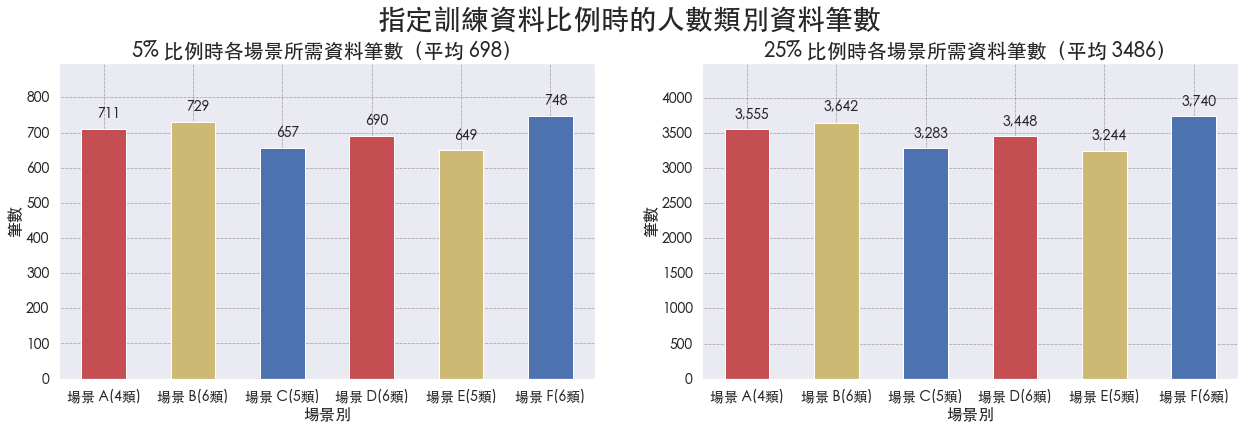

In [29]:
# 確認圖片佈局
column_count = 2
row_count = int(np.ceil(len(size_baseline) / column_count))

fig_height = 6 * row_count

# 設定子圖
plt.subplots(row_count, column_count, figsize=(18, fig_height))

for train_size in size_baseline:
    
    plot_df = records_df[records_df.train_size == train_size].loc[:, ['scenario', 'avg_records']].copy()
    plot_df.set_index('scenario', inplace=True)
    
    max_y = int(plot_df['avg_records'].max() * 1.2)
    ax = plt.subplot(row_count, column_count, size_baseline.index(train_size) + 1)
    plot_df.plot(kind='bar', 
                 ax=ax, 
                  color=colors,
                  ylim=(0, max_y),
                  legend = False)
    ax.set_xticklabels([f'場景 {scenario}({scenario_category_size[scenario]}類)' for scenario in plot_df.index], rotation=0)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel("場景別", fontsize=16)
    ax.set_ylabel("筆數", fontsize=16)
    ax.set_title(f'{train_size:.0%} 比例時各場景所需資料筆數（平均 {int(np.ceil(plot_df.avg_records.mean()))}）', fontsize=20)

    # 標示數字
    for idx, label in enumerate(list(plot_df.index)): 
        for acc in plot_df.columns:
            value = int(plot_df.iloc[idx][acc])
            ax.annotate(f'{value:,}',
                        (idx, value),
                         xytext=(5, 10), 
                         textcoords='offset points',
                        ha='center',
                        fontsize=14
                       )

plt.suptitle("指定訓練資料比例時的人數類別資料筆數", fontsize=28)
plt.subplots_adjust(bottom=0.12, top=0.85, left=0.06, right=0.97, hspace=0.25, wspace=0.2)
imgName = getImageName(f'records_threshold.png')
plt.savefig(imgName)
plt.show()
plt.close()



In [30]:
# 擷取各模型在各場景下、平面座標、訓練資料比例 75% 、隨機種子 3 時的學習成效
accuracy_df = pd.DataFrame()

df = exp_df[(exp_df.random_seed == 3) 
            & (exp_df.coordinate == 'cartesian') 
            & (exp_df.train_size == 0.75)].copy()
for idx, row in df.iterrows():
    train_report = row['train_report']
    test_report = row['test_report']
    data = {
        'model_name': row['model_name'],
        'scenario': row['scenario'],
        'test_kappa': row['test_kappa'],
        'train_kappa': row['train_kappa'],
        'test_accuracy': test_report['accuracy'],
        'train_accuracy': train_report['accuracy'],
        'train_size': row['train_size'],
    }
    accuracy_df = accuracy_df.append(data, ignore_index=True)
    


In [31]:
# 欲擷取的欄位
columns = ['train_size', 'scenario', 'model_name', 'test_accuracy', 'test_kappa']

# 取得各場景最佳演算法及成績
best_score_df = pd.DataFrame(columns = columns)


for scenario in scenario_list:
    idx = accuracy_df[(accuracy_df.scenario == scenario )]['test_accuracy'].idxmax()
    data = {}
    for column in columns:
        data[column] = accuracy_df.loc[idx, column]

    best_score_df = best_score_df.append(data, ignore_index=True)
    
best_score_df

train_size scenario            model_name  test_accuracy  test_kappa
0        0.75        A  KNeighborsClassifier       0.882543    0.843340
1        0.75        B         MLPClassifier       0.831785    0.797949
2        0.75        C  KNeighborsClassifier       0.978857    0.973555
3        0.75        D  KNeighborsClassifier       0.909882    0.891801
4        0.75        E  KNeighborsClassifier       0.968557    0.960664
5        0.75        F  KNeighborsClassifier       0.981681    0.978016